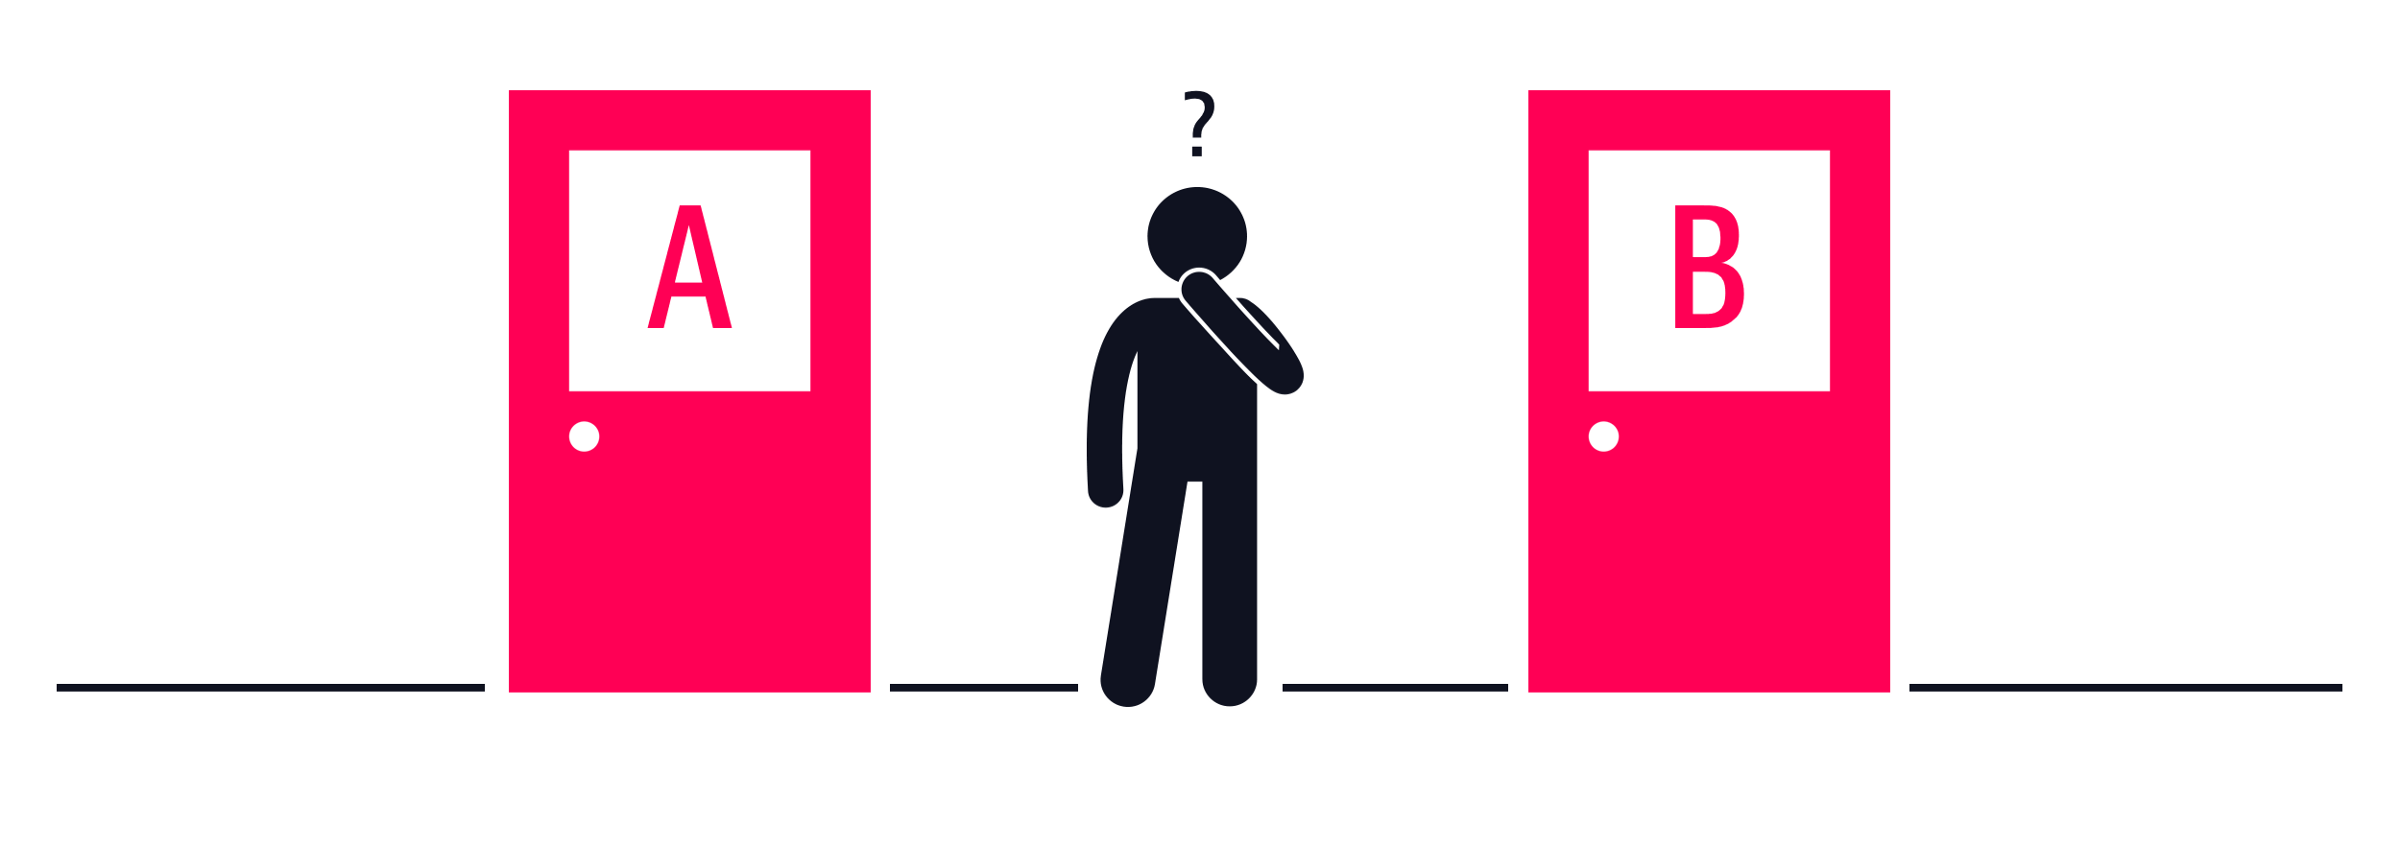

**TODO:** поправить все графики в одном формате.

https://towardsdatascience.com/styling-pandas-plots-and-charts-9b4721e9e597

## Библиотеки 

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(16,8)})

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')
from stattests.generation import generate_data
from stattests.tests import t_test
from stattests.utils import plot_cdf
from stattests.utils import frame_from_params, save_gif_and_show

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Подготовка

[Исходная статья](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f)

### Определение метрики CTR (click-through rate):

- Формула: (количество кликов / количество показов) * 100. Источник [Wiki_RU](https://ru.wikipedia.org/wiki/CTR_(%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BD%D0%B5%D1%82))
- Формула в статье: (количество кликов / количество уникальных пользователей) = "average number of clicks per user"

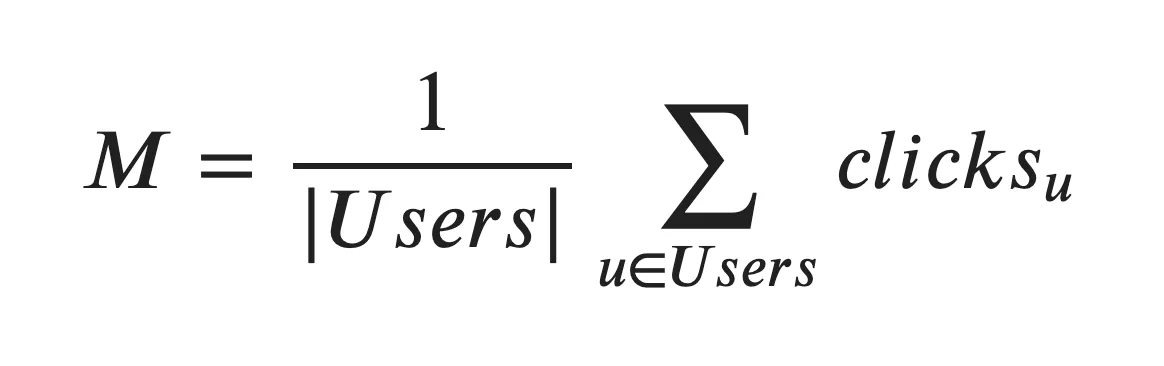

**Определение групп пользователей**:
- *Control group* - we will use our current production model
- *Treatment group* - we will deploy the new CTR prediction model

### Hypothesis Testing 

- The null hypothesis states that nothing has changed. In our example, it would be “the average number of clicks in the control and treatment groups are the same”.
- The alternative hypothesis says that there is a notable difference between groups.

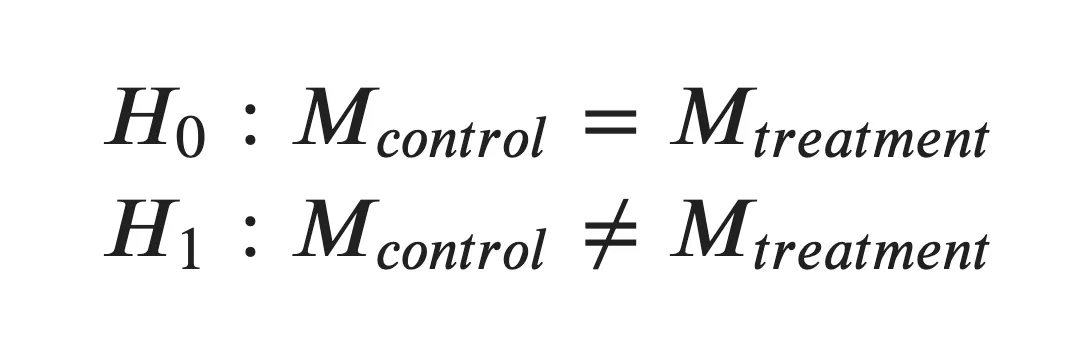

**False-positive rate (FPR)**  
FPR is the probability of rejecting H0 while it is actually true.  
If a statistical procedure is correct (all assumptions are met and the statistical test works fine with the given data), this rate is controlled by **p-value**.

**Sensitivity**  
Sensitivity is the probability of rejecting H0 while it is actually not true.

**Вопросы:**  
    - Как связаны FPR и ошибка первого рода? А Sensitivity и ошибка второго рода?  
    - Какие значения примет FPR и Sensitivity, если мы будем всегда принимать нулевую гипотезу? А если отвергать?

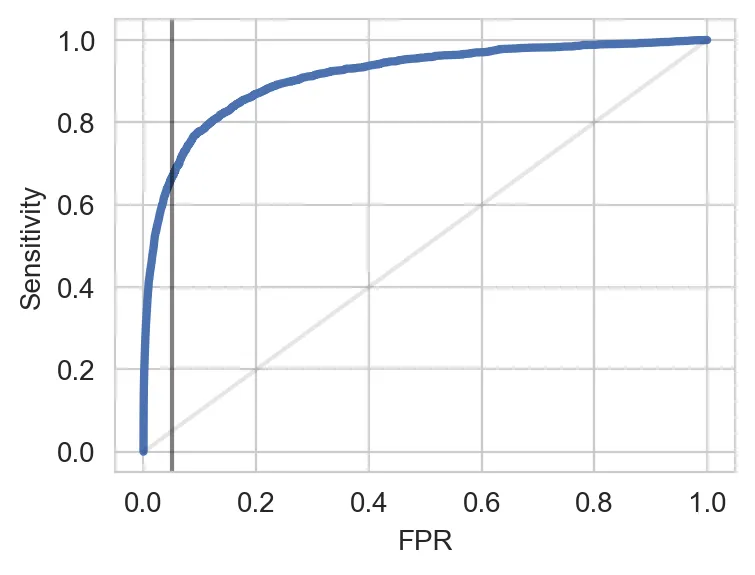

**FPR versus sensitivity (Mann-Whitney test)** 

The vertical grey line corresponds to 5% FPR, the standard p-value threshold. The intersection of this line with the curve gives you the sensitivity of your test that corresponds to 5% FPR. We will call it **the power of the statistical test** at 5% FPR (or just power). In this example, the power of the standard Mann-Whitney test at 5% FPR is 65%.

**The goal:**  
We will fix FPR to 5% and compare the powers of a vast variety of tests given this level.

**Power of the statistical test depends on four things:**

- The test itself
- Distribution of the experimental data
- Effect size
- Size of the test groups

### Data Generation 

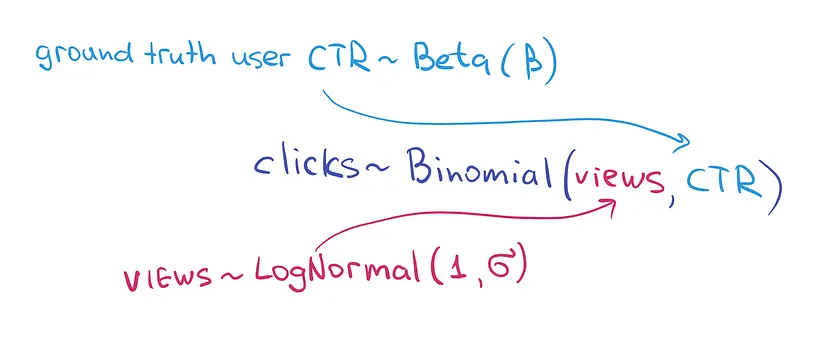

#### Views 

- skew: float, skewness of views distribution
- N: int, number of users in each experimental group (in control and in treatment)

In [3]:
skew = 2
N = 5000

[Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)  
[scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm)

In [4]:
views = np.exp(scipy.stats.norm(1, skew).rvs(N)).astype(int) + 1

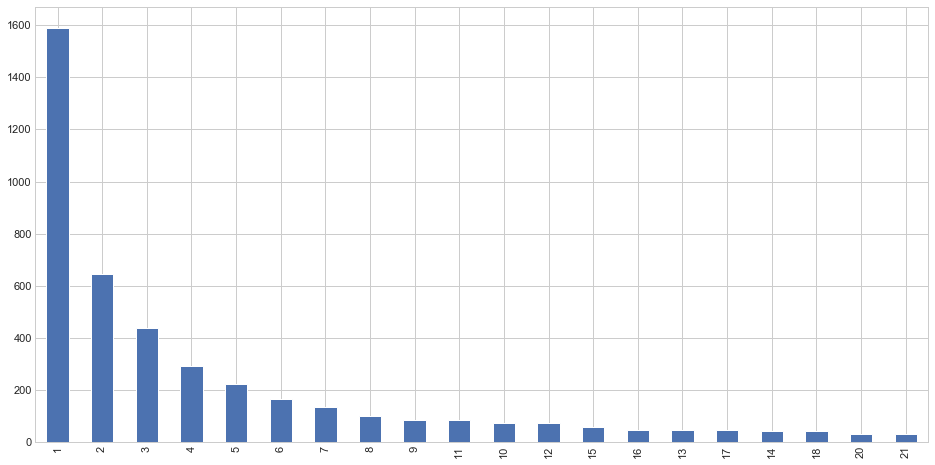

In [5]:
matplotlib.style.use('seaborn-whitegrid')
pd.Series(views).value_counts().iloc[0:20].plot(kind='bar', figsize=(16, 8))

Most of the users saw a small number of ads, and few users — a lot.

#### Ground Truth User CTR

- mean_success_rate: mean success rate in control group
- beta: parameter of success rate distribution

In [6]:
mean_success_rate = 0.2
beta = 1000

[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)  
[scipy.stats.beta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)

In [7]:
alpha = mean_success_rate * beta / (1 - mean_success_rate) # показать формулу среднего
success_rate = scipy.stats.beta(alpha, beta).rvs(N)

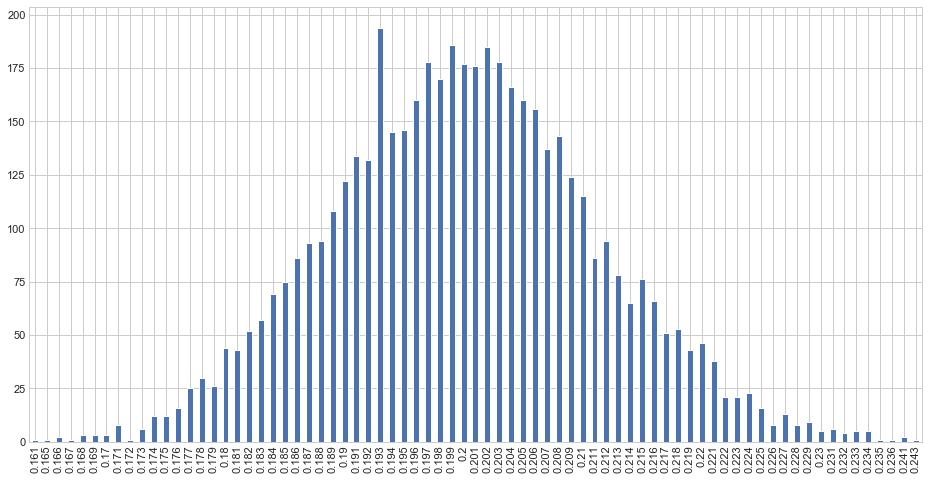

In [8]:
pd.Series(success_rate).round(3).value_counts().sort_index().plot(kind='bar', figsize=(16, 8))

#### Clicks

[Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)  
[scipy.stats.binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)

In [9]:
clicks = scipy.stats.binom(n=views, p=success_rate).rvs()

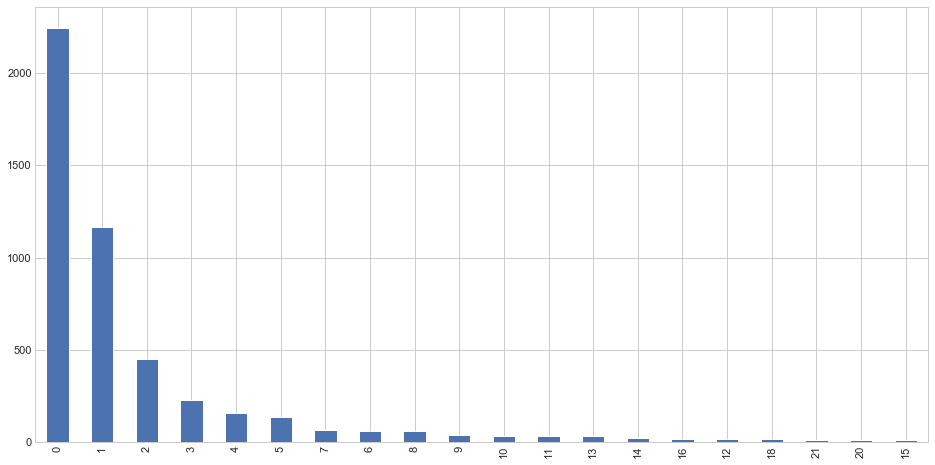

In [10]:
pd.Series(clicks).value_counts().iloc[0:20].plot(kind='bar', figsize=(16, 8))

#### Все вместе

In [11]:
df = pd.DataFrame(zip(views, success_rate, clicks), columns=['views', 'success_rate', 'clicks'])

In [12]:
df.head()

,views,success_rate,clicks
0,2,0.212657,0
1,5,0.214238,1
2,5,0.200181,0
3,1,0.186313,0
4,2,0.199551,1


In [13]:
df.shape

(5000, 3)

In [14]:
df.describe()

,views,success_rate,clicks
count,5000.000000,5000.000000,5000.000000
mean,20.494000,0.200000,4.129800
std,96.330796,0.011228,19.680244
min,1.000000,0.160835,0.000000
25%,1.000000,0.192439,0.000000
50%,3.000000,0.199838,1.000000
75%,11.000000,0.207346,2.000000
max,3182.000000,0.242804,671.000000


#### Treatment group  

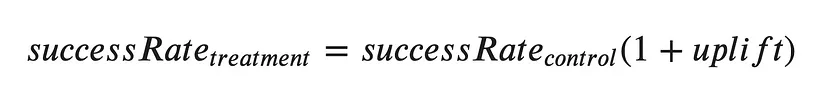

**Whole pipeline**
- Initialize N users for the control group, N for the treatment group.
- Generate the number of ad views for each user in treatment and control groups from the same log-normal distribution.
- Generate the ground truth user CTR for each user from beta-distribution with mean **success_rate_control** for the control group and **success_rate_control * (1 + uplift)** for the treatment group.
- Generate the number of ad clicks for each user from a binomial distribution with the number of trials equal to the number of views and the success rate equal to the ground truth user CTR.

Рассмотреть два случая:
- есть не нулевое улучшение
- изменений нет

In [15]:
ab_params = {'success_rate': 0.02,
             'uplift': 0.1,
             'beta': 1000,
             'skew': 2,
             'N': 10000,
             'NN': 1}
(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), (success_rates_0_ab, success_rates_1_ab) = generate_data(**ab_params)

df_control = pd.DataFrame(zip(views_0_ab[0], success_rates_0_ab[0], clicks_0_ab), columns=['views', 'success_rates', 'clicks'])
df_treatment = pd.DataFrame(zip(views_1_ab[0], success_rates_1_ab[0], clicks_1_ab), columns=['views','success_rates', 'clicks'])

In [16]:
df_control.head()

,views,success_rates,clicks
0,2.0,0.013462,0.0
1,4.0,0.019366,0.0
2,1.0,0.013883,0.0
3,5.0,0.017526,0.0
4,9.0,0.017719,0.0


In [17]:
df_control.shape

(10000, 3)

In [18]:
ctr_control = df_control.clicks.mean()
ctr_control

0.4192

In [19]:
ctr_treatment = df_treatment.clicks.mean()
ctr_treatment

0.4285

In [20]:
ctr_treatment / ctr_control

1.0221851145038168

In [21]:
df_control.clicks.describe()

count    10000.000000
mean         0.419200
std          2.377359
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        117.000000
Name: clicks, dtype: float64

In [22]:
df_treatment.clicks.describe()

count    10000.000000
mean         0.428500
std          2.477277
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        150.000000
Name: clicks, dtype: float64

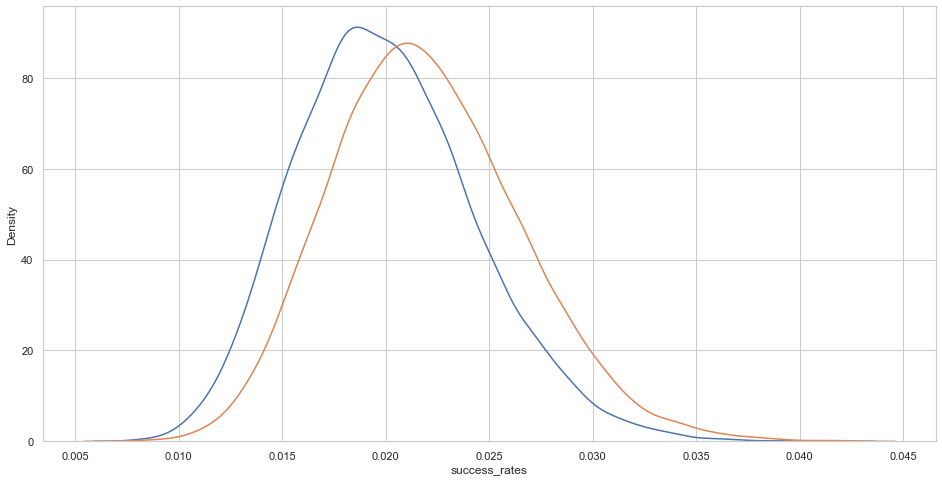

In [106]:
sns.distplot(df_control.success_rates, hist=False, label="Control")
sns.distplot(df_treatment.success_rates, hist=False, label="Treatment")

### Sensitivity and p-value CDF 

[Cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function)

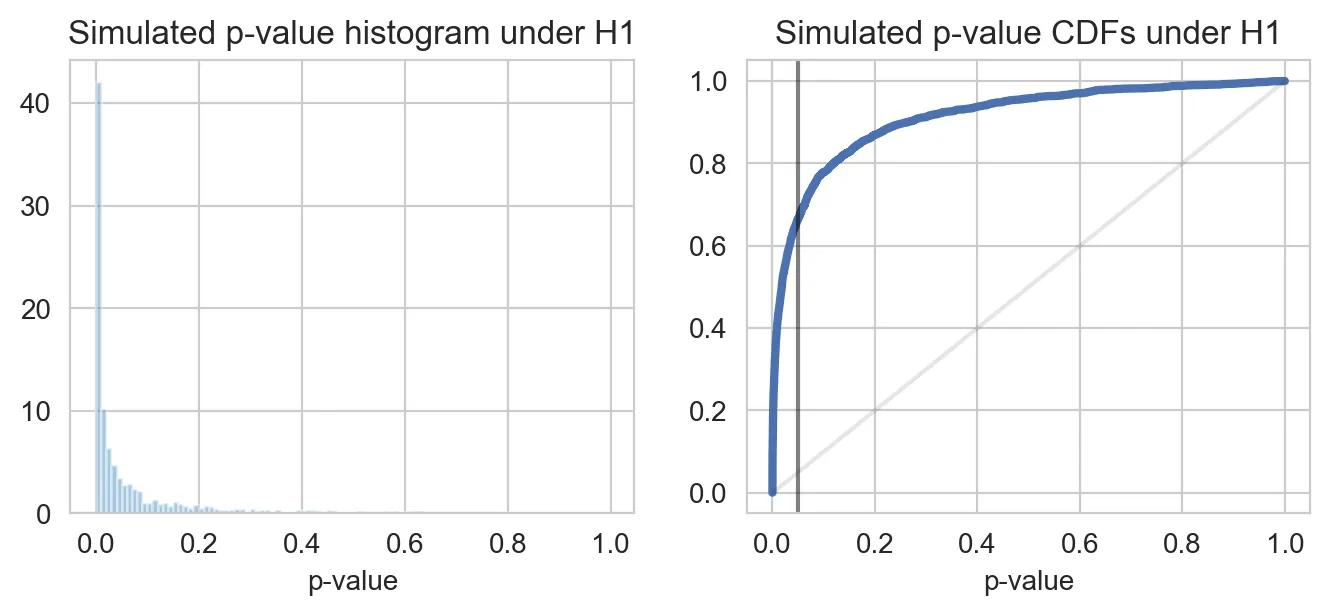

**Note how the p-value CDF here is actually equal to the statistical test sensitivity.** If we were to take the CDF’s value at 0.05 p-value, this would actually be the fraction of experiments when p-value <= 0.05. CDF(0.05) is the fraction of experiments when we reject H0. And as we know that H0 is not true in all experiments, CDF(0.05) is the fraction of experiments in which we reject H0 when H0 is actually not true (sensitivity). So the plot we see here is exactly the ROC curve for the statistical test (sensitivity vs FPR). We will use this approach to plot ROC curves for a wide variety of statistical tests and to compare them.

### P-value sanity check

- We always claim that False Positive Rate is controlled by a p-value threshold
- If p-value controls FPR reasonably well, the test will give us the correct results despite the violation of the assumptions.
- So for every statistical test, we should be able to check whether p-value controls FPR for our data.

A/A tests:
- Let’s use the same data generation pipeline, but with zero uplift.
- The p-value correctly controls FPR if and only if the p-value is distributed uniformly on [0, 1] for A/A tests.
-  We claim that in this case FPR is equal to our p-value threshold, e.g. for A/A tests, p-value falls below the 0.05 threshold in only 5% of cases. 

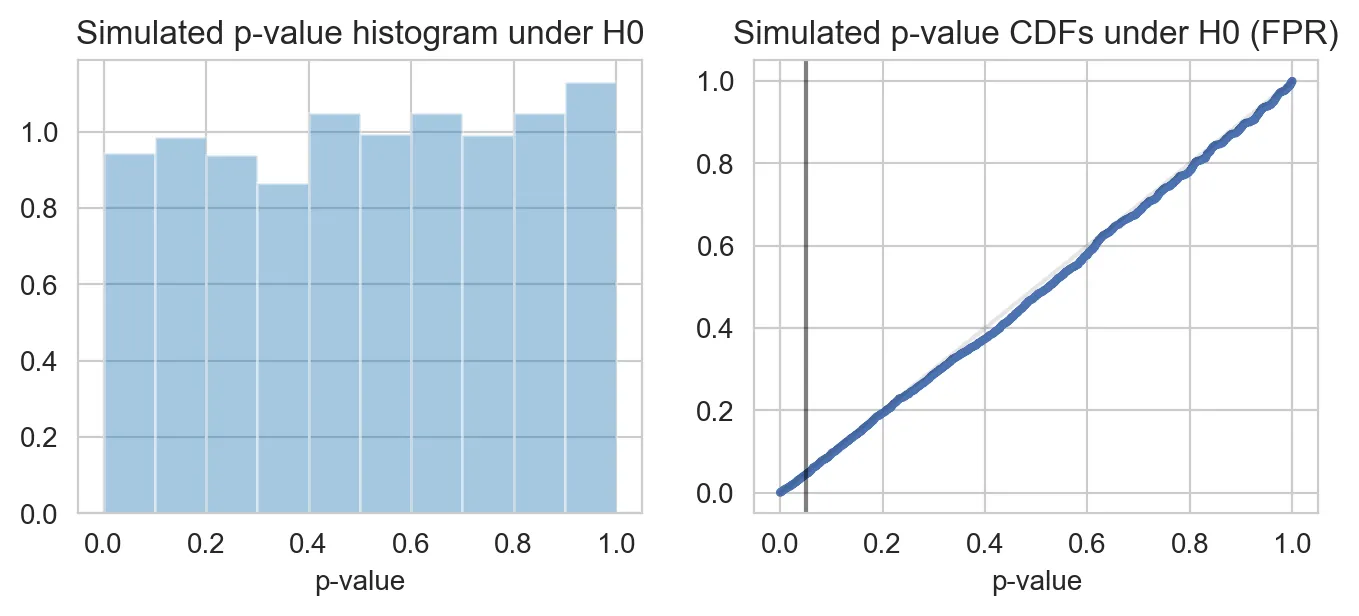

## Tests on the number of clicks

### Генерация данных (только одно сочетание параметров)

**Параметры по умолчанию**

In [1]:
skew = 1.0 # skewness of views distribution
N = 5000 # number of users in each experimental group (in control and in treatment)
NN = 2000 # number of experiments
success_rate = 0.02 # mean success rate in control group
uplift = 0.2 # relative uplift of mean success rate in treatment group
beta = 1000 # parameter of success rate distribution

In [33]:
ab_params = {'success_rate': success_rate,
             'uplift': uplift,
             'beta': beta,
             'skew': skew,
             'N': N,
             'NN': NN}

aa_params = {'success_rate': success_rate,
             'uplift': 0,
             'beta': beta,
             'skew': skew,
             'N': N,
             'NN': NN}

In [34]:
(views_0_ab, clicks_0_ab), (views_1_ab, clicks_1_ab), (success_rates_0_ab, success_rates_1_ab) = generate_data(**ab_params)
(views_0_aa, clicks_0_aa), (views_1_aa, clicks_1_aa), (success_rates_0_aa, success_rates_1_aa) = generate_data(**aa_params)

In [35]:
views_0_ab.shape

(2000, 5000)

In [36]:
clicks_0_ab.shape

(2000, 5000)

**Пример:**

In [37]:
i = 555

*Control*

In [38]:
views_control = views_0_ab[i,:]
clicks_control = clicks_0_ab[i,:]

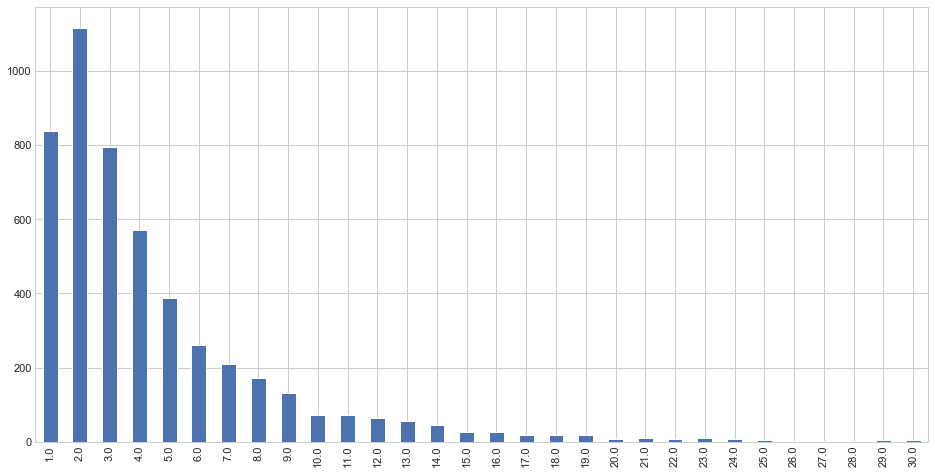

In [39]:
tmp_stats = pd.Series(views_control).value_counts().sort_index().loc[0:30]
tmp_stats.plot(kind='bar', figsize=(16, 8))

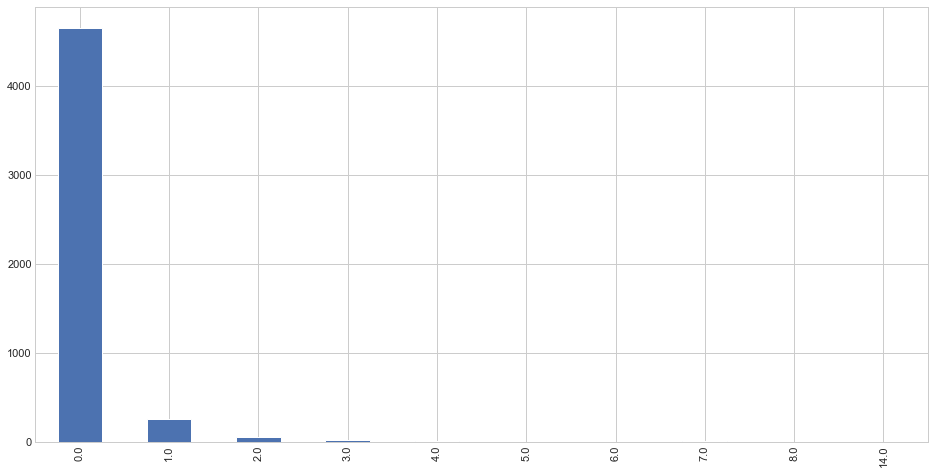

In [40]:
tmp_stats = pd.Series(clicks_control).value_counts().sort_index().loc[0:30]
tmp_stats.plot(kind='bar')

In [41]:
np.mean(clicks_control)

0.106

*Treatment*

In [42]:
views_treatment = views_1_ab[i,:]
clicks_treatment = clicks_1_ab[i,:]

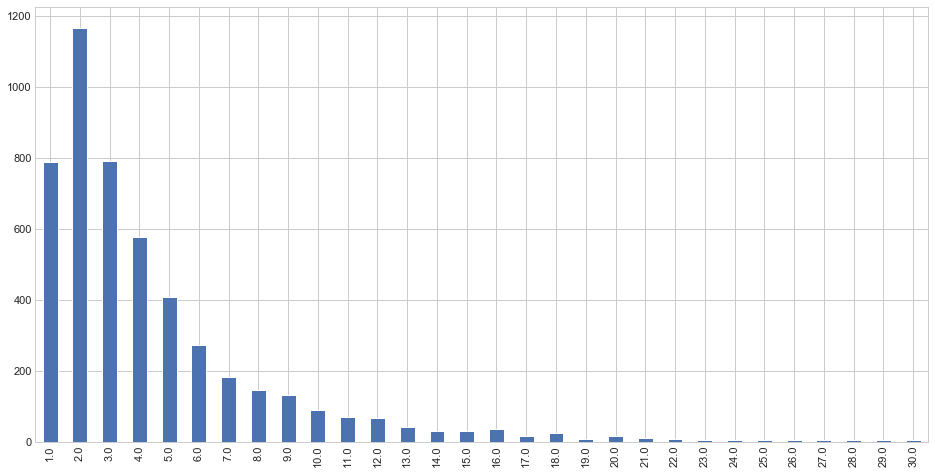

In [67]:
tmp_stats = pd.Series(views_treatment).value_counts().sort_index().loc[0:30]
tmp_stats.plot(kind='bar')

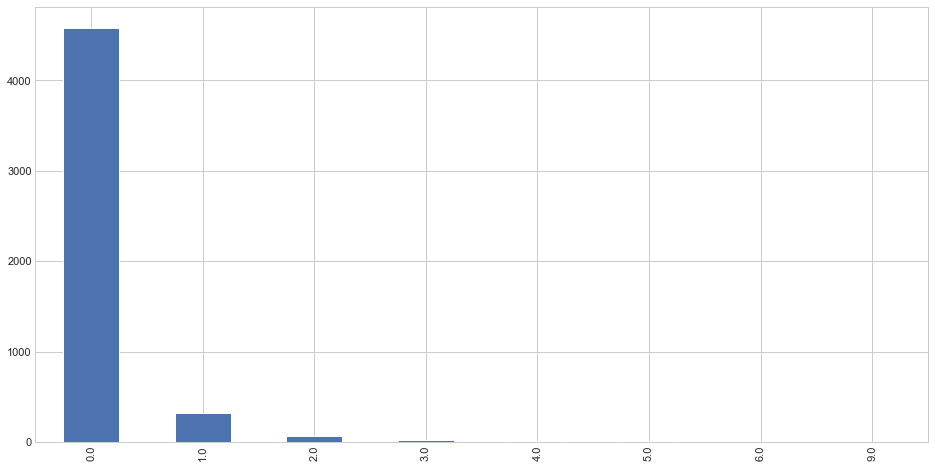

In [70]:
tmp_stats = pd.Series(clicks_treatment).value_counts().sort_index().loc[0:10]
tmp_stats.plot(kind='bar')

In [45]:
np.mean(clicks_treatment)

0.1228

*Control vs Treatment*

In [46]:
np.mean(clicks_treatment) / np.mean(clicks_control)

1.158490566037736

In [47]:
param

{'success_rate': 0.02,
 'uplift': 0.2,
 'beta': 8.858667904100825,
 'skew': 1.0,
 'N': 5000,
 'NN': 2000}

In [48]:
clicks_control.sum() / views_control.sum()

0.02222035887975851

In [49]:
pd.Series(map(np.mean, clicks_0_ab)).describe()

count    2000.000000
mean        0.099353
std         0.006889
min         0.080400
25%         0.094800
50%         0.099000
75%         0.103600
max         0.128000
dtype: float64

In [50]:
pd.Series(map(np.mean, clicks_1_ab)).describe()

count    2000.000000
mean        0.119698
std         0.007114
min         0.098000
25%         0.114800
50%         0.119600
75%         0.124400
max         0.144800
dtype: float64

**Проверка A/A теста**

In [51]:
pd.Series(map(np.mean, clicks_0_aa)).describe()

count    2000.000000
mean        0.099477
std         0.006678
min         0.082200
25%         0.095000
50%         0.099200
75%         0.103800
max         0.129600
dtype: float64

In [52]:
pd.Series(map(np.mean, clicks_1_aa)).describe()

count    2000.000000
mean        0.099445
std         0.006531
min         0.079200
25%         0.095000
50%         0.099200
75%         0.104200
max         0.121800
dtype: float64

In [53]:
pd.Series(map(np.mean, views_0_aa)).describe()

count    2000.000000
mean        4.978702
std         0.084226
min         4.696200
25%         4.920800
50%         4.979300
75%         5.036400
max         5.298600
dtype: float64

In [54]:
pd.Series(map(np.mean, views_1_aa)).describe()

count    2000.000000
mean        4.978135
std         0.084535
min         4.723200
25%         4.917000
50%         4.977600
75%         5.036100
max         5.215000
dtype: float64

###  T-test on the number of clicks 

#### Пример

T-tests involve strong assumptions on data, such as normality and equal variances among test groups. However, empirically, t-tests are robust to violations of the assumptions.

In [55]:
ab_data = t_test(clicks_0_ab, clicks_1_ab)
aa_data = t_test(clicks_0_aa, clicks_1_aa)

In [56]:
ab_data.shape

(2000,)

In [57]:
aa_data.shape

(2000,)

In [58]:
pd.Series(ab_data).describe()

count    2.000000e+03
mean     1.314217e-01
std      2.093626e-01
min      8.268900e-09
25%      5.336543e-03
50%      3.620315e-02
75%      1.542549e-01
max      1.000000e+00
dtype: float64

In [59]:
pd.Series(aa_data).describe()

count    2000.000000
mean        0.500980
std         0.292422
min         0.000371
25%         0.249139
50%         0.495997
75%         0.756758
max         1.000000
dtype: float64

Text(0, 0.5, 'Count of experiments')

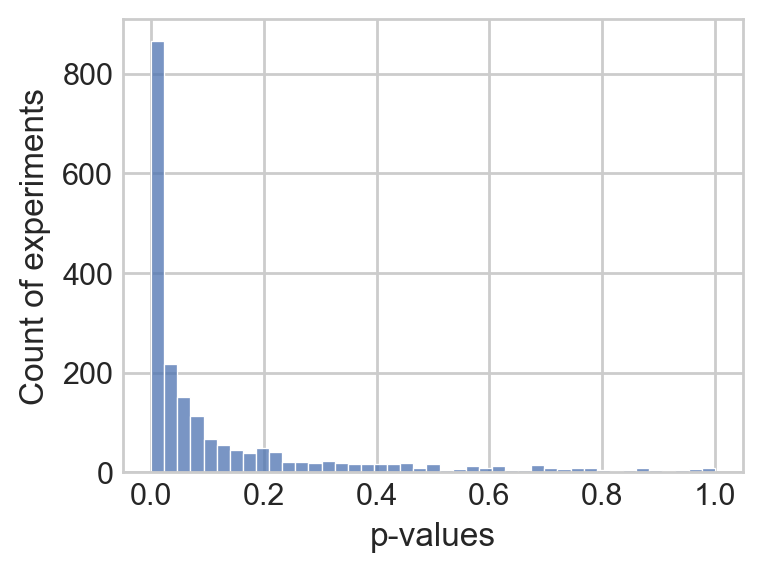

In [85]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
sns.histplot(ab_data)
ax.set_xlabel("p-values")
ax.set_ylabel("Count of experiments")

In [90]:
sum(ab_data < 0.05)

1108

In [91]:
sum(ab_data < 0.05) / ab_data.shape

array([0.554])

Text(0, 0.5, 'Sensitivity')

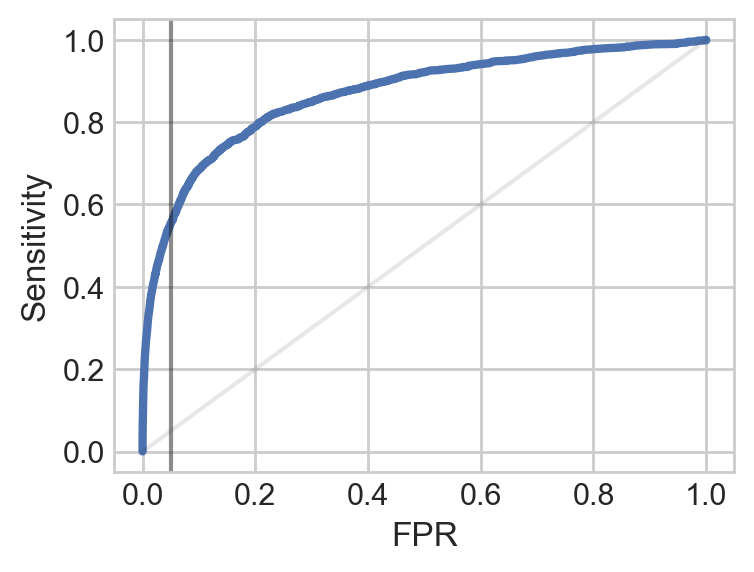

In [86]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
plot_cdf(ab_data, 'TTest', ax)
ax.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
ax.axvline(0.05, color='k', alpha=0.5)
ax.set_xlabel('FPR')
ax.set_ylabel('Sensitivity')

Text(0, 0.5, 'Count of experiments')

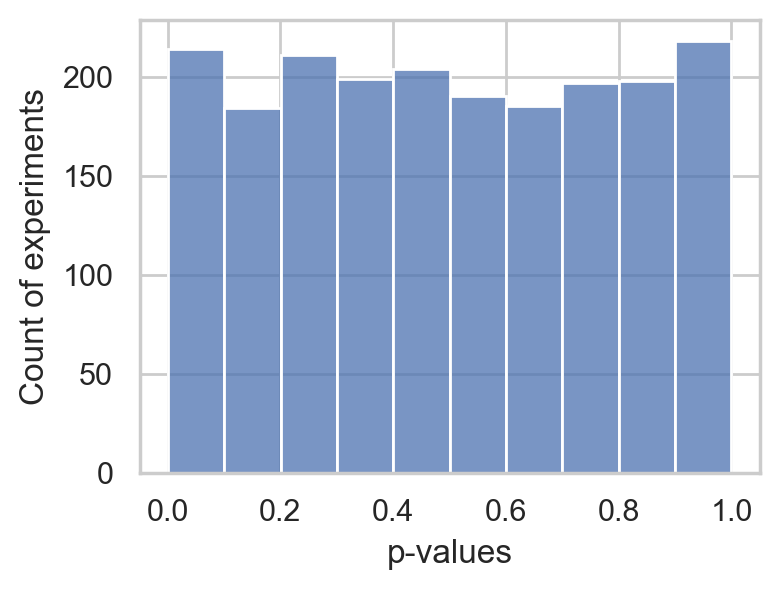

In [105]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
sns.histplot(aa_data, bins=10)
ax.set_xlabel("p-values")
ax.set_ylabel("Count of experiments")

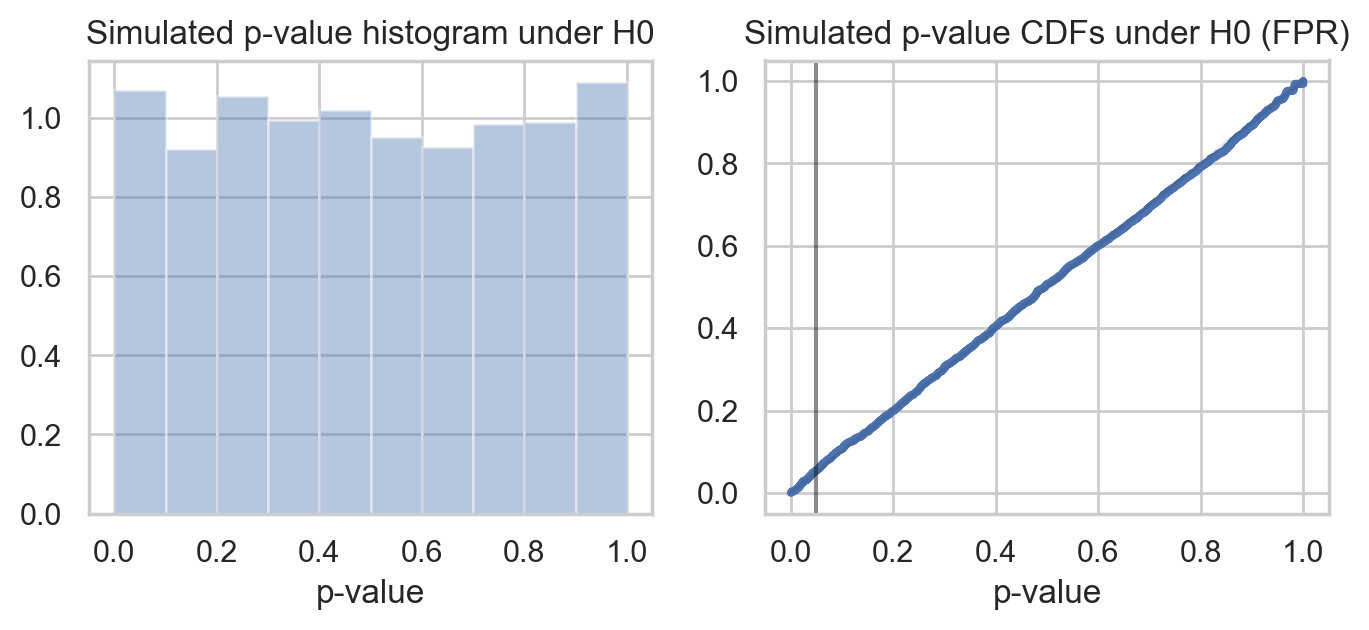

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=200)

plot_cdf(aa_data, 'T-test', ax2)

ax2.plot(np.linspace(0, 1, 10000), np.linspace(0, 1, 10000), 'k', alpha=0.1)
ax2.axvline(0.05, color='k', alpha=0.5)
ax2.set_title('Simulated p-value CDFs under H0 (FPR)')
ax2.set_xlabel('p-value')

ax1.set_title('Simulated p-value histogram under H0')
ax1.set_xlabel('p-value')
sns.distplot(aa_data.flatten(), ax=ax1, bins=10, kde=False, norm_hist=True)

**Собираем словарь различных значений**

In [6]:
skew_params = []
for s in np.linspace(0.1, 4, 20):
    skew_params.append({'success_rate': success_rate, 'uplift': uplift, 'beta': beta, 'skew': s, 'N': N, 'NN': NN})

In [7]:
print(np.linspace(0.1, 4, 20))

[0.1        0.30526316 0.51052632 0.71578947 0.92105263 1.12631579
 1.33157895 1.53684211 1.74210526 1.94736842 2.15263158 2.35789474
 2.56315789 2.76842105 2.97368421 3.17894737 3.38421053 3.58947368
 3.79473684 4.        ]


[Logarithmic scale](https://en.wikipedia.org/wiki/Logarithmic_scale)

In [8]:
beta_params = []
for b in np.logspace(0, 3, 20)[::-1]:
    beta_params.append({'success_rate': success_rate, 'uplift': uplift, 'beta': b, 'skew': skew, 'N': N, 'NN': NN})

In [9]:
print(np.logspace(0, 3, 20)[::-1])

[1000.          695.19279618  483.29302386  335.98182863  233.57214691
  162.37767392  112.88378917   78.47599704   54.55594781   37.92690191
   26.36650899   18.32980711   12.74274986    8.8586679     6.15848211
    4.2813324     2.97635144    2.06913808    1.43844989    1.        ]


In [10]:
sr_params = []
for sr in np.logspace(-3, -0.3, 20):
    sr_params.append({'success_rate': sr, 'uplift': uplift, 'beta': beta, 'skew': skew, 'N': N, 'NN': NN})

In [11]:
print(np.logspace(-3, -0.3, 20))

[0.001      0.00138709 0.00192402 0.0026688  0.00370187 0.00513483
 0.00712249 0.00987954 0.01370383 0.01900848 0.02636651 0.03657277
 0.0507298  0.0703669  0.09760536 0.13538762 0.18779508 0.26048905
 0.36132228 0.50118723]


**Всего различных сочетаний параметров**

In [12]:
param_list = skew_params + beta_params + sr_params
len(param_list)

60

**T-test при различных параметрах**

In [14]:
sns.set_style("whitegrid")
frames = [frame_from_params('../data', p, codenames=['ttest_successes_count']) for p in skew_params]
save_gif_and_show('../gifs/powers_ttest.gif', frames)

As you can see, higher skewness drops the power of the t-test significantly. Furthermore, for very skewed distributions, t-test p-values clearly don’t follow uniform distribution under H0. In the region of small values, p-values overestimate FPR (the plot lies beyond diagonal in this region). It becomes a “conservative” estimate of FPR. It is fine to use this test, as we can still be sure that FPR <= p-value, but the power of the test is low.

The main reason for this is the strong violation of the normality assumption for highly skewed distribution. If the views distribution is heavily skewed, clicks distribution will be skewed as well. The more it is skewed, the more samples (users) are required to restore the sample’s mean normality.

План:
- добавить MW - везде
- добавить собственный бутстреп
- добавить проверку CTR
- написать выводы